In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("="*80)
print("DBT DEEP LEARNING ANALYSIS")
print("="*80)

DBT DEEP LEARNING ANALYSIS



DATA PREPROCESSING
Dataset Shape: (3825, 9)
Fiscal Years: ['2019-2020' '2020-2021' '2021-2022' '2022-2023' '2023-2024']
Number of Districts: 760

Time Series Data Shape: (50, 8)

Sample Data:
       state_name         fy  total_dbt_transfer  no_of_dbt_transactions  \
0  Andhra Pradesh  2019-2020         60369736199                88329730   
1  Andhra Pradesh  2020-2021        282534990117               333078218   
2  Andhra Pradesh  2021-2022        343209553462               366750092   
3  Andhra Pradesh  2022-2023        311495974403               273621282   
4  Andhra Pradesh  2023-2024         62959083567                60006011   
5           Bihar  2019-2020         19603500000                84640988   
6           Bihar  2020-2021        582671480839               529437744   
7           Bihar  2021-2022        574293392885               707427747   
8           Bihar  2022-2023        642960377748               742075930   
9           Bihar  2023-2024         5263543261

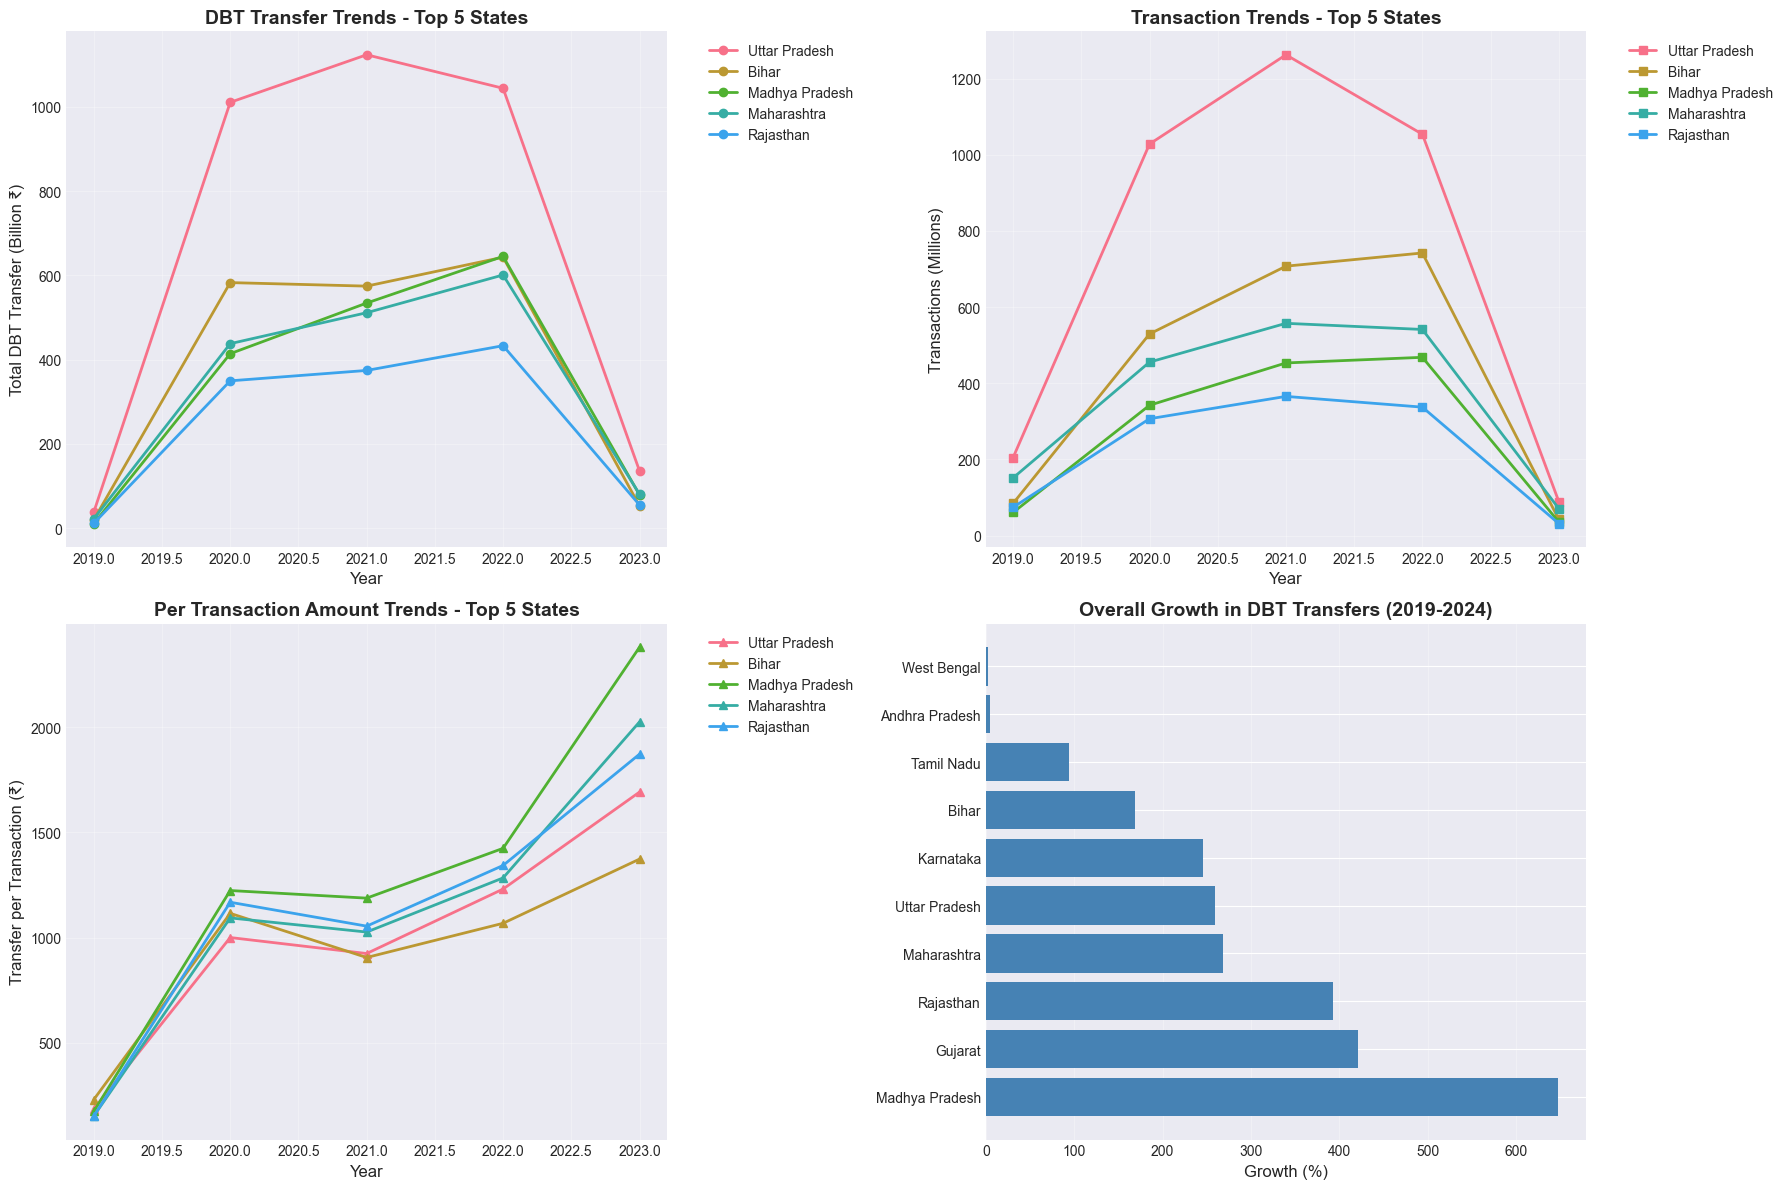

In [2]:
# ============================================================================
# DATA PREPROCESSING
# ============================================================================
print("\n" + "="*80)
print("DATA PREPROCESSING")
print("="*80)

# Load data
df = pd.read_csv('../clean_dbt_district_wise.csv')

print(f"Dataset Shape: {df.shape}")
print(f"Fiscal Years: {df['fy'].unique()}")
print(f"Number of Districts: {df['district_name'].nunique()}")

# Create time series data for major states
major_states = df.groupby('state_name')['total_dbt_transfer'].sum().nlargest(10).index.tolist()
df_major = df[df['state_name'].isin(major_states)].copy()

# Aggregate by state and fiscal year
df_ts = df_major.groupby(['state_name', 'fy']).agg({
    'total_dbt_transfer': 'sum',
    'no_of_dbt_transactions': 'sum',
    'transfer_per_transaction': 'mean'
}).reset_index()

# Sort by state and fiscal year
df_ts = df_ts.sort_values(['state_name', 'fy']).reset_index(drop=True)

# Create year column
df_ts['year'] = df_ts['fy'].str.split('-').str[0].astype(int)

# Convert to billions for better scale
df_ts['total_dbt_transfer_bn'] = df_ts['total_dbt_transfer'] / 1e9
df_ts['transactions_millions'] = df_ts['no_of_dbt_transactions'] / 1e6

print("\nTime Series Data Shape:", df_ts.shape)
print("\nSample Data:")
print(df_ts.head(10))

# Visualize trends for major states
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Total Transfer Trends
for state in major_states[:5]:
    state_data = df_ts[df_ts['state_name'] == state]
    axes[0, 0].plot(state_data['year'], state_data['total_dbt_transfer_bn'], 
                    marker='o', linewidth=2, label=state)
axes[0, 0].set_xlabel('Year', fontsize=12)
axes[0, 0].set_ylabel('Total DBT Transfer (Billion ₹)', fontsize=12)
axes[0, 0].set_title('DBT Transfer Trends - Top 5 States', fontsize=14, fontweight='bold')
axes[0, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0, 0].grid(True, alpha=0.3)

# Transaction Trends
for state in major_states[:5]:
    state_data = df_ts[df_ts['state_name'] == state]
    axes[0, 1].plot(state_data['year'], state_data['transactions_millions'], 
                    marker='s', linewidth=2, label=state)
axes[0, 1].set_xlabel('Year', fontsize=12)
axes[0, 1].set_ylabel('Transactions (Millions)', fontsize=12)
axes[0, 1].set_title('Transaction Trends - Top 5 States', fontsize=14, fontweight='bold')
axes[0, 1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0, 1].grid(True, alpha=0.3)

# Transfer per Transaction Trends
for state in major_states[:5]:
    state_data = df_ts[df_ts['state_name'] == state]
    axes[1, 0].plot(state_data['year'], state_data['transfer_per_transaction'], 
                    marker='^', linewidth=2, label=state)
axes[1, 0].set_xlabel('Year', fontsize=12)
axes[1, 0].set_ylabel('Transfer per Transaction (₹)', fontsize=12)
axes[1, 0].set_title('Per Transaction Amount Trends - Top 5 States', fontsize=14, fontweight='bold')
axes[1, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1, 0].grid(True, alpha=0.3)

# Year-over-Year Growth
growth_data = []
for state in major_states:
    state_df = df_ts[df_ts['state_name'] == state].sort_values('year')
    if len(state_df) > 1:
        growth = ((state_df['total_dbt_transfer_bn'].iloc[-1] - 
                  state_df['total_dbt_transfer_bn'].iloc[0]) / 
                 state_df['total_dbt_transfer_bn'].iloc[0] * 100)
        growth_data.append({'State': state, 'Growth': growth})

growth_df = pd.DataFrame(growth_data).sort_values('Growth', ascending=False)
axes[1, 1].barh(growth_df['State'], growth_df['Growth'], color='steelblue')
axes[1, 1].set_xlabel('Growth (%)', fontsize=12)
axes[1, 1].set_title('Overall Growth in DBT Transfers (2019-2024)', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('01_data_trends.png', dpi=300, bbox_inches='tight')
plt.show()

# %%

In [3]:
# ============================================================================
# PREPARE SEQUENCE DATA FOR DEEP LEARNING
# ============================================================================

def create_sequences(data, seq_length):
    """Create sequences for time series prediction"""
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# Prepare data for each state
sequence_length = 3
all_X, all_y, all_states = [], [], []

for state in major_states:
    state_data = df_ts[df_ts['state_name'] == state].sort_values('year')
    
    if len(state_data) >= sequence_length + 1:
        # Use multiple features
        features = state_data[['total_dbt_transfer_bn', 'transactions_millions', 
                               'transfer_per_transaction']].values
        
        X_seq, y_seq = create_sequences(features, sequence_length)
        
        all_X.append(X_seq)
        all_y.append(y_seq)
        all_states.extend([state] * len(X_seq))

# Combine all sequences
X_combined = np.vstack(all_X)
y_combined = np.vstack(all_y)

print(f"\nSequence Data Shape: X={X_combined.shape}, y={y_combined.shape}")

# Scale the data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_reshaped = X_combined.reshape(-1, X_combined.shape[-1])
X_scaled = scaler_X.fit_transform(X_reshaped).reshape(X_combined.shape)
y_scaled = scaler_y.fit_transform(y_combined)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.2, random_state=42, shuffle=True
)

print(f"Training Set: X={X_train.shape}, y={y_train.shape}")
print(f"Test Set: X={X_test.shape}, y={y_test.shape}")


Sequence Data Shape: X=(20, 3, 3), y=(20, 3)
Training Set: X=(16, 3, 3), y=(16, 3)
Test Set: X=(4, 3, 3), y=(4, 3)


In [4]:
# ============================================================================
# MODEL 1: LSTM FOR TIME SERIES FORECASTING
# ============================================================================
print("\n" + "="*80)
print("MODEL 1: LSTM NETWORK")
print("="*80)

# Build LSTM model
lstm_model = Sequential([
    layers.LSTM(128, activation='relu', return_sequences=True, 
                input_shape=(X_train.shape[1], X_train.shape[2])),
    layers.Dropout(0.3),
    layers.LSTM(64, activation='relu', return_sequences=True),
    layers.Dropout(0.3),
    layers.LSTM(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(16, activation='relu'),
    layers.Dense(y_train.shape[1])
])

lstm_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

print("\nLSTM Model Architecture:")
lstm_model.summary()

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-6)

# Train model
print("\nTraining LSTM Model...")
lstm_history = lstm_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=16,
    callbacks=[early_stop, reduce_lr],
    verbose=0
)

# Evaluate
y_pred_lstm = lstm_model.predict(X_test, verbose=0)
y_pred_lstm_inv = scaler_y.inverse_transform(y_pred_lstm)
y_test_inv = scaler_y.inverse_transform(y_test)

# Calculate metrics
mse_lstm = mean_squared_error(y_test_inv, y_pred_lstm_inv)
mae_lstm = mean_absolute_error(y_test_inv, y_pred_lstm_inv)
rmse_lstm = np.sqrt(mse_lstm)
r2_lstm = r2_score(y_test_inv, y_pred_lstm_inv)

print(f"\nLSTM Model Performance:")
print(f"  MSE: {mse_lstm:.4f}")
print(f"  MAE: {mae_lstm:.4f}")
print(f"  RMSE: {rmse_lstm:.4f}")
print(f"  R² Score: {r2_lstm:.4f}")


MODEL 1: LSTM NETWORK

LSTM Model Architecture:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 128)            67584     
                                                                 
 dropout (Dropout)           (None, 3, 128)            0         
                                                                 
 lstm_1 (LSTM)               (None, 3, 64)             49408     
                                                                 
 dropout_1 (Dropout)         (None, 3, 64)             0         
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense 

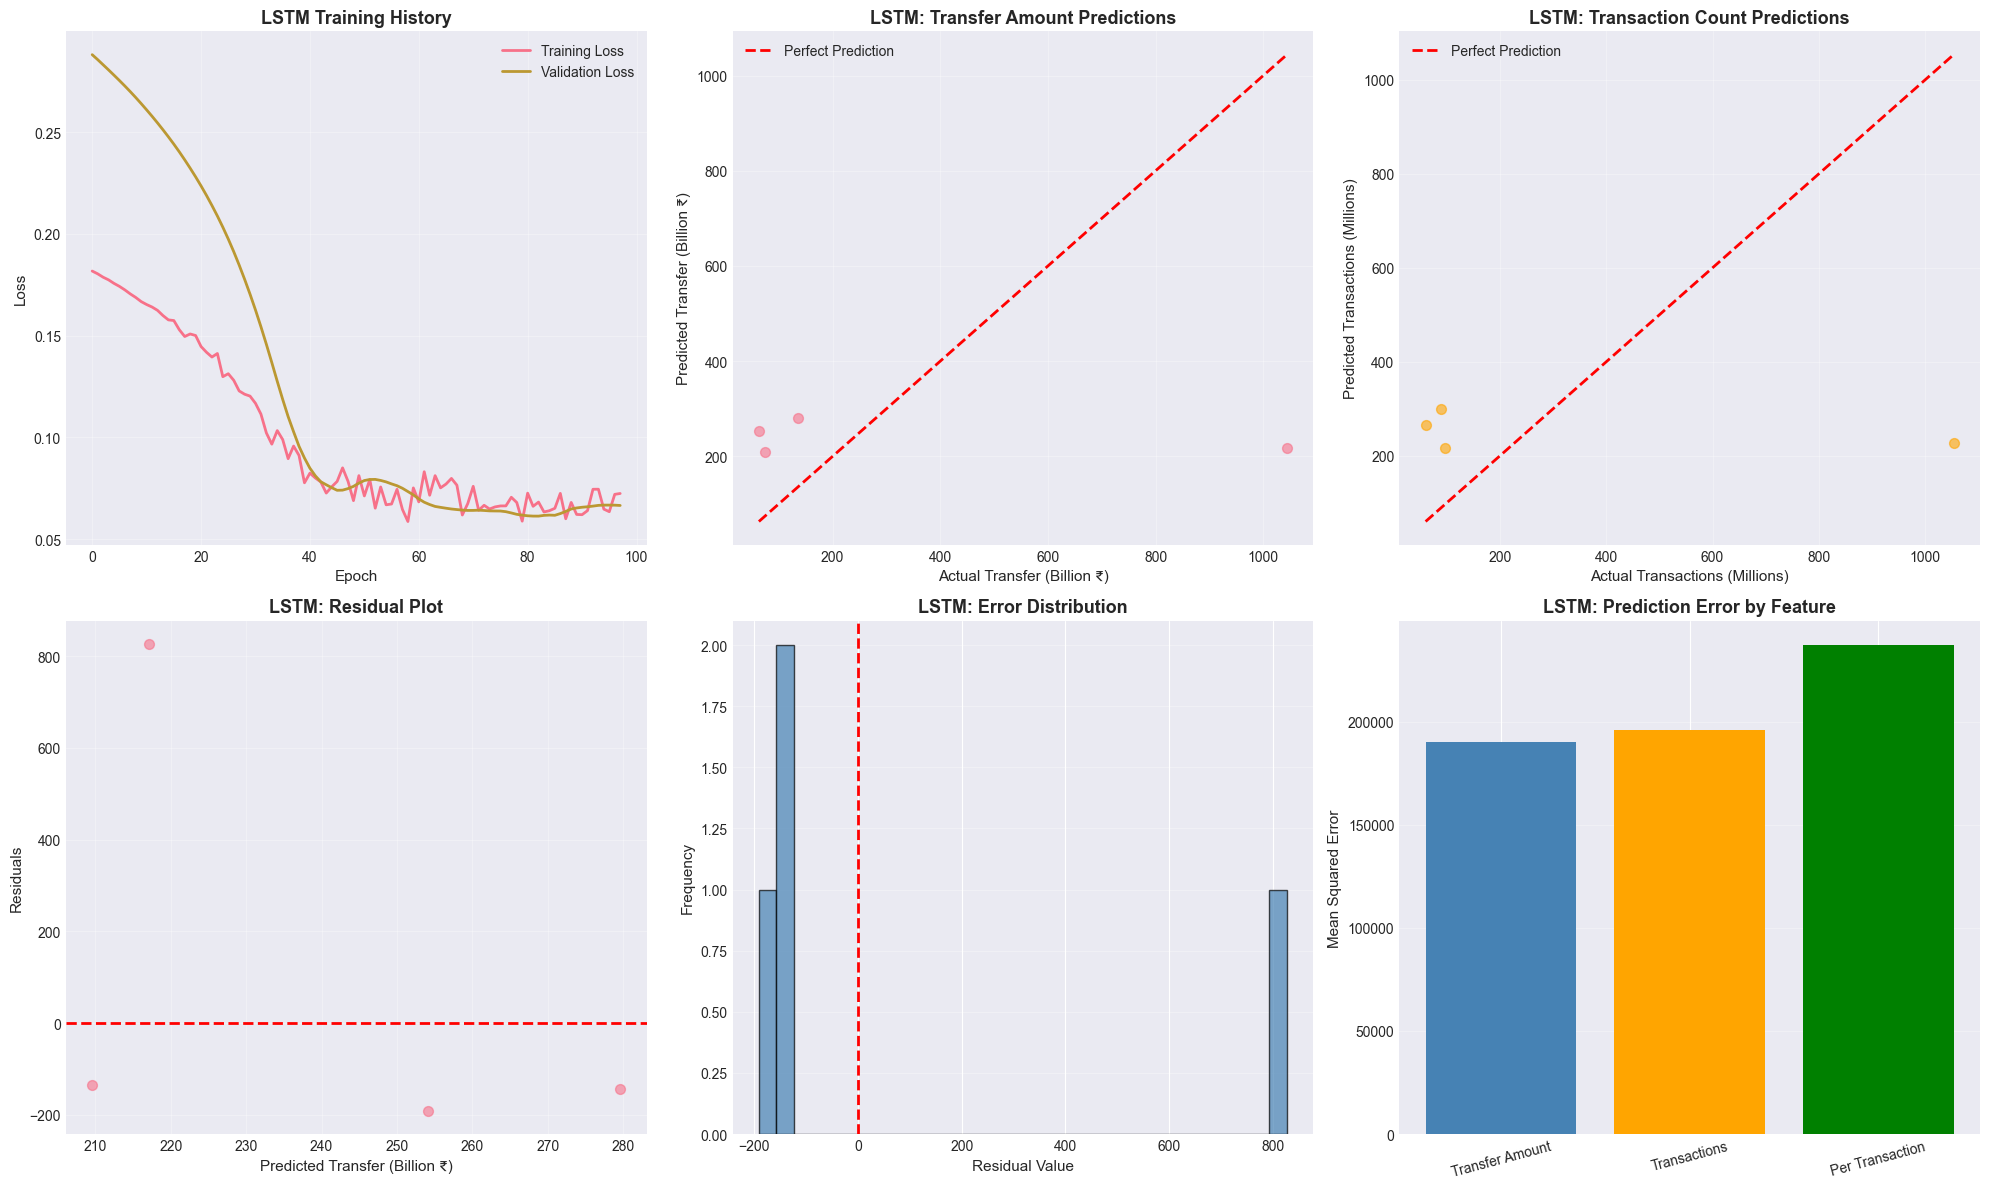

In [5]:
# Visualizations for LSTM
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# 1. Training History
axes[0, 0].plot(lstm_history.history['loss'], label='Training Loss', linewidth=2)
axes[0, 0].plot(lstm_history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0, 0].set_xlabel('Epoch', fontsize=11)
axes[0, 0].set_ylabel('Loss', fontsize=11)
axes[0, 0].set_title('LSTM Training History', fontsize=13, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Predictions vs Actual - Transfer Amount
axes[0, 1].scatter(y_test_inv[:, 0], y_pred_lstm_inv[:, 0], alpha=0.6, s=50)
axes[0, 1].plot([y_test_inv[:, 0].min(), y_test_inv[:, 0].max()], 
                [y_test_inv[:, 0].min(), y_test_inv[:, 0].max()], 
                'r--', linewidth=2, label='Perfect Prediction')
axes[0, 1].set_xlabel('Actual Transfer (Billion ₹)', fontsize=11)
axes[0, 1].set_ylabel('Predicted Transfer (Billion ₹)', fontsize=11)
axes[0, 1].set_title('LSTM: Transfer Amount Predictions', fontsize=13, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Predictions vs Actual - Transactions
axes[0, 2].scatter(y_test_inv[:, 1], y_pred_lstm_inv[:, 1], alpha=0.6, s=50, color='orange')
axes[0, 2].plot([y_test_inv[:, 1].min(), y_test_inv[:, 1].max()], 
                [y_test_inv[:, 1].min(), y_test_inv[:, 1].max()], 
                'r--', linewidth=2, label='Perfect Prediction')
axes[0, 2].set_xlabel('Actual Transactions (Millions)', fontsize=11)
axes[0, 2].set_ylabel('Predicted Transactions (Millions)', fontsize=11)
axes[0, 2].set_title('LSTM: Transaction Count Predictions', fontsize=13, fontweight='bold')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# 4. Residual Plot
residuals = y_test_inv[:, 0] - y_pred_lstm_inv[:, 0]
axes[1, 0].scatter(y_pred_lstm_inv[:, 0], residuals, alpha=0.6, s=50)
axes[1, 0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Predicted Transfer (Billion ₹)', fontsize=11)
axes[1, 0].set_ylabel('Residuals', fontsize=11)
axes[1, 0].set_title('LSTM: Residual Plot', fontsize=13, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# 5. Error Distribution
axes[1, 1].hist(residuals, bins=30, color='steelblue', alpha=0.7, edgecolor='black')
axes[1, 1].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[1, 1].set_xlabel('Residual Value', fontsize=11)
axes[1, 1].set_ylabel('Frequency', fontsize=11)
axes[1, 1].set_title('LSTM: Error Distribution', fontsize=13, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')

# 6. Feature Importance (using prediction variance)
feature_names = ['Transfer Amount', 'Transactions', 'Per Transaction']
mse_by_feature = [mean_squared_error(y_test_inv[:, i], y_pred_lstm_inv[:, i]) 
                  for i in range(y_test_inv.shape[1])]
axes[1, 2].bar(feature_names, mse_by_feature, color=['steelblue', 'orange', 'green'])
axes[1, 2].set_ylabel('Mean Squared Error', fontsize=11)
axes[1, 2].set_title('LSTM: Prediction Error by Feature', fontsize=13, fontweight='bold')
axes[1, 2].tick_params(axis='x', rotation=15)
axes[1, 2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

In [6]:
# ============================================================================
# MODEL 3: AUTOENCODER FOR ANOMALY DETECTION
# ============================================================================
print("\n" + "="*80)
print("MODEL 2: AUTOENCODER FOR ANOMALY DETECTION")
print("="*80)

# Prepare data for autoencoder (use all data for unsupervised learning)
X_ae = X_scaled.reshape(X_scaled.shape[0], -1)  # Flatten sequences
scaler_ae = StandardScaler()
X_ae_scaled = scaler_ae.fit_transform(X_ae)

# Build Autoencoder
encoding_dim = 16

# Encoder
encoder_input = layers.Input(shape=(X_ae_scaled.shape[1],))
encoded = layers.Dense(64, activation='relu')(encoder_input)
encoded = layers.Dropout(0.2)(encoded)
encoded = layers.Dense(32, activation='relu')(encoded)
encoded = layers.Dropout(0.2)(encoded)
encoded = layers.Dense(encoding_dim, activation='relu')(encoded)

# Decoder
decoded = layers.Dense(32, activation='relu')(encoded)
decoded = layers.Dropout(0.2)(decoded)
decoded = layers.Dense(64, activation='relu')(decoded)
decoded = layers.Dropout(0.2)(decoded)
decoded = layers.Dense(X_ae_scaled.shape[1], activation='linear')(decoded)

# Autoencoder model
autoencoder = Model(encoder_input, decoded)
encoder = Model(encoder_input, encoded)

autoencoder.compile(optimizer='adam', loss='mse')

print("\nAutoencoder Architecture:")
autoencoder.summary()

# Train autoencoder
print("\nTraining Autoencoder...")
ae_history = autoencoder.fit(
    X_ae_scaled, X_ae_scaled,
    epochs=100,
    batch_size=16,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr],
    verbose=0
)

# Get reconstructions
X_reconstructed = autoencoder.predict(X_ae_scaled, verbose=0)

# Calculate reconstruction errors
reconstruction_errors = np.mean(np.square(X_ae_scaled - X_reconstructed), axis=1)

# Determine anomaly threshold (95th percentile)
threshold = np.percentile(reconstruction_errors, 95)
anomalies = reconstruction_errors > threshold

print(f"\nAnomaly Detection Results:")
print(f"  Total samples: {len(reconstruction_errors)}")
print(f"  Anomalies detected: {np.sum(anomalies)} ({np.sum(anomalies)/len(anomalies)*100:.2f}%)")
print(f"  Reconstruction error threshold: {threshold:.6f}")
print(f"  Mean reconstruction error: {np.mean(reconstruction_errors):.6f}")
print(f"  Std reconstruction error: {np.std(reconstruction_errors):.6f}")

# Get encoded representations
encoded_data = encoder.predict(X_ae_scaled, verbose=0)


MODEL 2: AUTOENCODER FOR ANOMALY DETECTION

Autoencoder Architecture:
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 9)]               0         
                                                                 
 dense_2 (Dense)             (None, 64)                640       
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 16)                528       
                                                        

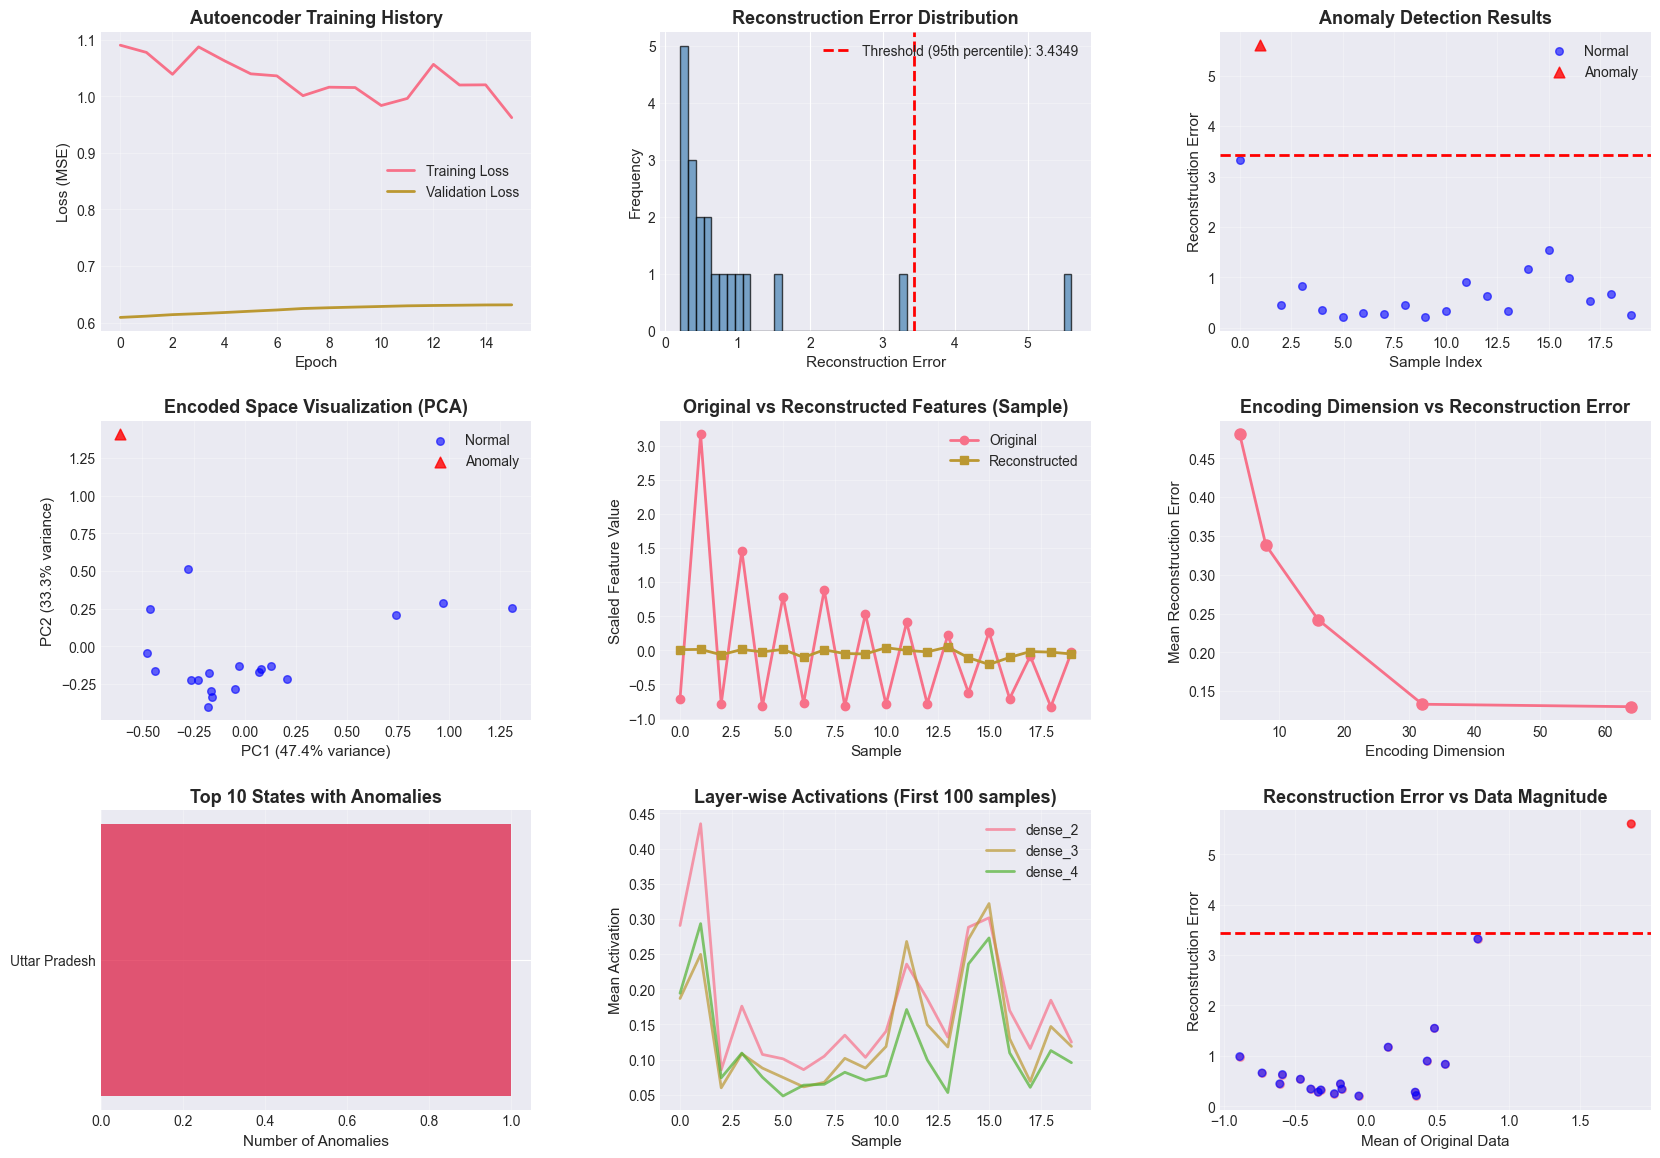

In [7]:
# Get encoded representations
encoded_data = encoder.predict(X_ae_scaled, verbose=0)

# Visualizations for Autoencoder
fig = plt.figure(figsize=(20, 14))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Training History
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(ae_history.history['loss'], label='Training Loss', linewidth=2)
ax1.plot(ae_history.history['val_loss'], label='Validation Loss', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=11)
ax1.set_ylabel('Loss (MSE)', fontsize=11)
ax1.set_title('Autoencoder Training History', fontsize=13, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Reconstruction Error Distribution
ax2 = fig.add_subplot(gs[0, 1])
ax2.hist(reconstruction_errors, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
ax2.axvline(x=threshold, color='r', linestyle='--', linewidth=2, 
           label=f'Threshold (95th percentile): {threshold:.4f}')
ax2.set_xlabel('Reconstruction Error', fontsize=11)
ax2.set_ylabel('Frequency', fontsize=11)
ax2.set_title('Reconstruction Error Distribution', fontsize=13, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

# 3. Anomaly Scatter Plot
ax3 = fig.add_subplot(gs[0, 2])
normal_mask = ~anomalies
ax3.scatter(np.arange(len(reconstruction_errors))[normal_mask], 
           reconstruction_errors[normal_mask], 
           c='blue', alpha=0.6, s=30, label='Normal')
ax3.scatter(np.arange(len(reconstruction_errors))[anomalies], 
           reconstruction_errors[anomalies], 
           c='red', alpha=0.8, s=60, label='Anomaly', marker='^')
ax3.axhline(y=threshold, color='r', linestyle='--', linewidth=2)
ax3.set_xlabel('Sample Index', fontsize=11)
ax3.set_ylabel('Reconstruction Error', fontsize=11)
ax3.set_title('Anomaly Detection Results', fontsize=13, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Encoded Space Visualization (2D PCA)
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
encoded_pca = pca.fit_transform(encoded_data)

ax4 = fig.add_subplot(gs[1, 0])
ax4.scatter(encoded_pca[normal_mask, 0], encoded_pca[normal_mask, 1], 
           c='blue', alpha=0.6, s=30, label='Normal')
ax4.scatter(encoded_pca[anomalies, 0], encoded_pca[anomalies, 1], 
           c='red', alpha=0.8, s=60, label='Anomaly', marker='^')
ax4.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=11)
ax4.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=11)
ax4.set_title('Encoded Space Visualization (PCA)', fontsize=13, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

# 5. Feature Reconstruction Comparison
feature_idx = 0  # First feature
original_feature = X_ae_scaled[:30, feature_idx]
reconstructed_feature = X_reconstructed[:30, feature_idx]

ax5 = fig.add_subplot(gs[1, 1])
ax5.plot(original_feature, 'o-', label='Original', linewidth=2, markersize=6)
ax5.plot(reconstructed_feature, 's-', label='Reconstructed', linewidth=2, markersize=6)
ax5.set_xlabel('Sample', fontsize=11)
ax5.set_ylabel('Scaled Feature Value', fontsize=11)
ax5.set_title('Original vs Reconstructed Features (Sample)', fontsize=13, fontweight='bold')
ax5.legend()
ax5.grid(True, alpha=0.3)

# 6. Encoding Dimension Analysis
encoding_dims = [4, 8, 16, 32, 64]
reconstruction_errors_by_dim = []

for dim in encoding_dims:
    temp_encoder_input = layers.Input(shape=(X_ae_scaled.shape[1],))
    temp_encoded = layers.Dense(64, activation='relu')(temp_encoder_input)
    temp_encoded = layers.Dense(dim, activation='relu')(temp_encoded)
    temp_decoded = layers.Dense(64, activation='relu')(temp_encoded)
    temp_decoded = layers.Dense(X_ae_scaled.shape[1], activation='linear')(temp_decoded)
    
    temp_ae = Model(temp_encoder_input, temp_decoded)
    temp_ae.compile(optimizer='adam', loss='mse')
    temp_ae.fit(X_ae_scaled, X_ae_scaled, epochs=30, batch_size=16, verbose=0)
    
    temp_reconstructed = temp_ae.predict(X_ae_scaled, verbose=0)
    temp_error = np.mean(np.square(X_ae_scaled - temp_reconstructed))
    reconstruction_errors_by_dim.append(temp_error)

ax6 = fig.add_subplot(gs[1, 2])
ax6.plot(encoding_dims, reconstruction_errors_by_dim, 'o-', linewidth=2, markersize=8)
ax6.set_xlabel('Encoding Dimension', fontsize=11)
ax6.set_ylabel('Mean Reconstruction Error', fontsize=11)
ax6.set_title('Encoding Dimension vs Reconstruction Error', fontsize=13, fontweight='bold')
ax6.grid(True, alpha=0.3)

# 7. State-wise Anomaly Analysis
# Map anomalies back to states
anomaly_states = []
for i, is_anomaly in enumerate(anomalies):
    if is_anomaly and i < len(all_states):
        anomaly_states.append(all_states[i])

from collections import Counter
state_anomaly_counts = Counter(anomaly_states)
top_anomaly_states = dict(sorted(state_anomaly_counts.items(), 
                                 key=lambda x: x[1], reverse=True)[:10])

ax7 = fig.add_subplot(gs[2, 0])
if top_anomaly_states:
    ax7.barh(list(top_anomaly_states.keys()), list(top_anomaly_states.values()), 
            color='crimson', alpha=0.7)
    ax7.set_xlabel('Number of Anomalies', fontsize=11)
    ax7.set_title('Top 10 States with Anomalies', fontsize=13, fontweight='bold')
    ax7.grid(True, alpha=0.3, axis='x')
else:
    ax7.text(0.5, 0.5, 'No anomalies detected', ha='center', va='center', fontsize=12)
    ax7.set_title('State-wise Anomaly Distribution', fontsize=13, fontweight='bold')

# 8. Error by Encoding Layer
layer_names = [layer.name for layer in autoencoder.layers if 'dense' in layer.name][:3]
layer_outputs = []
for layer_name in layer_names:
    intermediate_model = Model(inputs=autoencoder.input,
                              outputs=autoencoder.get_layer(layer_name).output)
    layer_outputs.append(intermediate_model.predict(X_ae_scaled[:100], verbose=0))

ax8 = fig.add_subplot(gs[2, 1])
for i, (name, output) in enumerate(zip(layer_names, layer_outputs)):
    ax8.plot(np.mean(np.abs(output), axis=1), label=name, linewidth=2, alpha=0.7)
ax8.set_xlabel('Sample', fontsize=11)
ax8.set_ylabel('Mean Activation', fontsize=11)
ax8.set_title('Layer-wise Activations (First 100 samples)', fontsize=13, fontweight='bold')
ax8.legend()
ax8.grid(True, alpha=0.3)

# 9. Reconstruction Error vs Original Data Statistics
original_means = np.mean(X_ae_scaled, axis=1)
ax9 = fig.add_subplot(gs[2, 2])
ax9.scatter(original_means, reconstruction_errors, alpha=0.6, s=30)
colors = ['red' if a else 'blue' for a in anomalies]
ax9.scatter(original_means, reconstruction_errors, c=colors, alpha=0.6, s=30)
ax9.set_xlabel('Mean of Original Data', fontsize=11)
ax9.set_ylabel('Reconstruction Error', fontsize=11)
ax9.set_title('Reconstruction Error vs Data Magnitude', fontsize=13, fontweight='bold')
ax9.axhline(y=threshold, color='r', linestyle='--', linewidth=2)
ax9.grid(True, alpha=0.3)

plt.savefig('04_autoencoder_analysis.png', dpi=300, bbox_inches='tight')
plt.show()